# Objective
Predict Kaggle competition home credit default risk

https://www.kaggle.com/c/home-credit-default-risk/data

# Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from zipfile import ZipFile
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split

In [2]:
%load_ext pycodestyle_magic
%flake8_on
%matplotlib inline

### Create folder structure

In [3]:
# Make root folder the current working directory
os.chdir('..')

In [4]:
input_folder = './data/raw/'

In [5]:
cleaned_folder = './data/processed/'

In [6]:
output_folder = './reports/figures/'

## Data import

In [7]:
zip_file = ZipFile(input_folder+'home-credit-default-risk.zip')
application_train_df = pd.read_csv(zip_file.open('application_train.csv'))

In [8]:
zip_file = ZipFile(input_folder+'home-credit-default-risk.zip')
application_test_df = pd.read_csv(zip_file.open('application_test.csv'))

# Data cleaning

## General

In [9]:
# Merge test and train data for cleaning with column to distinguish
application_test_df['train'] = 0
application_train_df['train'] = 1
application_df = pd.concat([application_train_df, application_test_df]).reset_index(drop=True)

In [10]:
application_test_df = application_test_df.copy()

In [11]:
application_df.shape

(356255, 123)

## Column selection

In [12]:
# Select columns which can be used for financially excluded customers
column_selection = ['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE',
                    'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
                    'CNT_CHILDREN', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE',
                    'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS',
                    'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE',
                    'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                    'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL',
                    'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                    'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
                    'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
                    'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
                    'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
                    'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                    'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
                    'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE',
                    'APARTMENTS_AVG', 'BASEMENTAREA_AVG',
                    'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG',
                    'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
                    'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
                    'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG',
                    'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG',
                    'APARTMENTS_MODE', 'BASEMENTAREA_MODE',
                    'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE',
                    'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE',
                    'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE',
                    'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE',
                    'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE',
                    'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI',
                    'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI',
                    'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI',
                    'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI',
                    'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI',
                    'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI',
                    'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'TOTALAREA_MODE',
                    'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE',
                    'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE',
                    'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE',
                    'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2',
                    'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5',
                    'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8',
                    'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11',
                    'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14',
                    'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17',
                    'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20',
                    'FLAG_DOCUMENT_21', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
                    'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'train']

application_df = application_df[column_selection]

12:80: E501 line too long (80 > 79 characters)
14:80: E501 line too long (80 > 79 characters)


## Continuous variables

### Remove outliers

In [13]:
column_selection = list(application_df.select_dtypes(include=['float64']))

In [14]:
# Transform values DAYS_REGISTRATION from negative to positive in order to be able to apply IQR method
application_df['DAYS_REGISTRATION'] = application_df['DAYS_REGISTRATION'] * -1

1:80: E501 line too long (102 > 79 characters)


In [15]:
application_df.shape

(356255, 114)

In [16]:
# Remove outliers in continous features using IQR based on columns selected in exploratory analysis
column_selection = list(application_df.select_dtypes(include=['float64']))

column_selection.remove('TARGET')
dataframe = application_df
rows_remove = []

for column in column_selection:
    IQR_sorted = sorted(dataframe[column])
    IQR = dataframe[column].median()
    Q1 = np.percentile(IQR_sorted, [25])
    Q3 = np.percentile(IQR_sorted, [75])
    lower_bound = (Q1 - (1.6 * IQR)).item()
    upper_bound = (Q3 + (1.6 * IQR)).item()
    rows = dataframe[(dataframe[column] < lower_bound) |
                     (dataframe[column] > upper_bound)].index.tolist()
    rows_remove = rows_remove + rows

print("Outliers dropped:", (len(rows_remove)/len(dataframe.index))*100, '%')

# Drop outlier customers from dataframe
application_df = application_df.loc[~application_df.index.isin(rows_remove)]

Outliers dropped: 7.389931369384289 %


1:80: E501 line too long (99 > 79 characters)


In [17]:
application_df.shape

(332918, 114)

## Categorical data

In [18]:
application_df = application_df.copy()

In [19]:
dataframe['ORGANIZATION_TYPE'].value_counts()

Business Entity Type 3    78832
XNA                       64648
Self-employed             44332
Other                     19390
Medicine                  12909
Business Entity Type 2    12032
Government                11912
School                    10180
Trade: type 7              9134
Kindergarten               7918
Construction               7760
Business Entity Type 1     6871
Transport: type 4          6282
Trade: type 3              4070
Industry: type 9           3867
Industry: type 3           3767
Security                   3719
Housing                    3393
Military                   3164
Industry: type 11          3120
Bank                       2881
Police                     2782
Agriculture                2746
Transport: type 2          2652
Postal                     2451
Security Ministries        2315
Trade: type 2              2142
Restaurant                 2095
Services                   1877
University                 1548
Industry: type 7           1524
Transpor

In [20]:
# Recode organisation subcategories into one main category (eg 'Trade: type 6 -> 'Trade)
column = application_df['ORGANIZATION_TYPE']
types = ['Trade', 'Industry', 'Transport', 'Business']

for item in types:
    column.loc[column.str.startswith(item, na=False)] = item

C:\Users\michiel.HEPSTAR\AppData\Local\Continuum\anaconda3a\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
1:80: E501 line too long (88 > 79 characters)


In [21]:
# Create 'Other' category for categorical outliers
threshold = 0.01
dataframe = application_df
for col in dataframe[['ORGANIZATION_TYPE', 'NAME_INCOME_TYPE']]:
    value_counts = dataframe[col].value_counts(normalize=True)
    below_threshold = value_counts[value_counts <= threshold].index.tolist()
    dataframe[col].replace(to_replace=below_threshold, value="Other", inplace=True)

In [22]:
# Remove rows with outlier categorical values
column_selection = list(application_df.select_dtypes(include=['object']))
threshold_percent = 0.01

for columns in column_selection:
    # Select rows falling below threshold
    rows_below_threshold = application_df[application_df[columns].map(application_df[columns].value_counts(normalize=True, dropna=False) < threshold_percent)]
    if len(rows_below_threshold.index) > 0:
        application_df.drop(rows_below_threshold.index, inplace=True)
    else:
        continue

7:80: E501 line too long (158 > 79 characters)


## Missing data

In [23]:
# drop features with 50% or more missing data
missing_data = application_df.isna().sum() / application_df.isna().count() * 100
features_missing = list(missing_data[missing_data > 50].keys())
application_df.drop(features_missing, axis=1, inplace=True)

2:80: E501 line too long (80 > 79 characters)


In [24]:
# Replace 'XNA' with the most frequent occuring gender response
freq = application_df['CODE_GENDER'].value_counts().index.tolist()[0]
application_df['CODE_GENDER'].replace('XNA', freq, inplace=False)
application_df['CODE_GENDER'].isna().sum()

0

In [25]:
# Calculate the missing data % in training data
missing = application_df.isna().sum() / application_df.isna().count() * 100
missing = missing[missing >0]
missing

TARGET                      13.440550
OCCUPATION_TYPE             32.354113
OBS_30_CNT_SOCIAL_CIRCLE     0.260745
DEF_30_CNT_SOCIAL_CIRCLE     0.260745
OBS_60_CNT_SOCIAL_CIRCLE     0.260745
DEF_60_CNT_SOCIAL_CIRCLE     0.260745
DAYS_LAST_PHONE_CHANGE       0.000329
AMT_ANNUITY                  0.009877
dtype: float64

3:28: E225 missing whitespace around operator


In [26]:
# Drop cases with between 0-1% of missing data
minimal_missing = missing[(missing > 0) & (missing < 1)]
minimal_missing = list(minimal_missing.index)
application_df.dropna(axis=0, subset=minimal_missing, inplace=True)
print("Cases from the following columns were dropped:", minimal_missing)

Cases from the following columns were dropped: ['OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY']


In [27]:
list(application_df.columns[application_df.isna().any()])

['TARGET', 'OCCUPATION_TYPE']

In [28]:
# Predict the missing values of continous features
num_columns = list(application_df.select_dtypes(include=['float64']).columns)
df = application_df[num_columns].copy()

cols_nan = list(df.columns[df.isna().any()])
cols_no_nan = list(df.columns.difference(cols_nan).values)

cols_nan.remove('TARGET')

for col in cols_nan:
    test_data = df[df[col].isna()]
    train_data = df.dropna()
    model = KNeighborsRegressor(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
    application_df.loc[application_df[col].isna(), col] = model.predict(test_data[cols_no_nan])

13:80: E501 line too long (92 > 79 characters)


# Predict the missing values of TOTALAREA_MODE through lineair regression
column = 'TOTALAREA_MODE'
num_columns = list(application_df.select_dtypes(include=['float64']).columns)
df = application_df[num_columns].copy()

df.drop(['TARGET', 'SK_ID_CURR'], axis=1, inplace=True)
test_df = df[df[column].isnull()]
df.dropna(inplace=True)

y_train = df[column]
X_train = df.drop(column, axis=1)
X_test = test_df.drop(column, axis=1)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Replace missing values with predicted
application_df.loc[np.isnan(application_df[column]), column] = y_pred

In [29]:
df = application_df.copy()

cols_nan = list(df.columns[df.isna().any()])
cols_no_nan = df.columns.difference(cols_nan).values
cat_var = list(df.select_dtypes(include=['O', 'object', 'datetime64']).columns)
cols_no_nan = [x for x in cols_no_nan if x not in cat_var]

cols_no_nan.remove('SK_ID_CURR')
cols_nan.remove('TARGET')

for col in cols_nan:
    test_data = df[df[col].isna()]
    train_data = df.dropna()
    model = KNeighborsClassifier(n_neighbors=5).fit(train_data[cols_no_nan], train_data[col])
    application_df.loc[application_df[col].isna(), col] = model.predict(test_data[cols_no_nan])

14:80: E501 line too long (93 > 79 characters)


In [30]:
# Calculate the missing data % in training data
train_missing_data = application_df.isna().sum() / application_df.isna().count() * 100
train_missing_data[train_missing_data > 0]

TARGET    13.464852
dtype: float64

2:80: E501 line too long (86 > 79 characters)


## Dummify categorical variables

In [31]:
application_df.shape

(302922, 66)

In [32]:
# Dummify categorical features
column_selection = list(application_df.select_dtypes(include=['object']))
# Create dummies of categorical features
application_df = pd.get_dummies(application_df, columns=column_selection, drop_first=True)

In [33]:
application_df.head(2)

,SK_ID_CURR,TARGET,CNT_CHILDREN,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,...,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_School,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA
0,100002,1.0,0,0.018801,-9461,-637,3648.0,-2120,1,1,...,0,0,0,0,0,0,0,0,0,0
1,100003,0.0,0,0.003541,-16765,-1188,1186.0,-291,1,1,...,0,0,0,0,1,0,0,0,0,0


In [34]:
application_df.shape

(302922, 102)

# Feature creation

## Feature loan % of  income

In [35]:
application_df = application_df.copy()

In [36]:
application_df['creditVSincome'] = application_df['AMT_CREDIT'] / application_df['AMT_INCOME_TOTAL']

## Polynominal feature creation

In [37]:
# Create a list of features
all_columns = list(application_df.select_dtypes(include=['float64', 'int64']))
no_feat = ['index', 'TARGET', 'SK_ID_CURR', 'train']
num_features = list(filter(lambda x: x not in no_feat, all_columns))

In [38]:
def add_interactions(df):
    # Get feature names
    combos = list(combinations(list(df.columns), 2))
    colnames = list(df.columns) + ['_'.join(x) for x in combos]

    # Find interactions
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    df = poly.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames

    # Remove interaction terms with all 0 values
    noint_indicies = [i for i, x in enumerate(list((df == 0).all())) if x]
    df = df.drop(df.columns[noint_indicies], axis=1)

    return df
# Credit: https://medium.com/joguei-os-dados/week-4-feature-engineering-4787fca0f809

17:80: E501 line too long (84 > 79 characters)
17:80: E501 line too long (84 > 79 characters)


In [39]:
# Add polynominal features
polynominal_df = add_interactions(application_df[num_features])

In [40]:
application_df = application_df.merge(polynominal_df, how='outer')

# Feature selection

In [41]:
application_df.shape

(302938, 1255)

In [42]:
train_df = application_df[~application_df['TARGET'].isnull()]

In [43]:
y = train_df['TARGET']

In [44]:
# Create a list of features
all_columns = list(train_df.columns)
no_feat = ['TARGET', 'SK_ID_CURR', 'train']
features = list(filter(lambda x: x not in no_feat, all_columns))

# Square scores to make negative scores positive
scores2 = np.square(scores)

feature_scores_df = pd.DataFrame()
feature_scores_df['features'] = features
feature_scores_df['scores2'] = scores2

feature_scores_df.mean()

feature_scores_df

feature_scores_df = feature_scores_df.sort_values(by='scores2', ascending=False)

feature_scores_df.plot.bar()

feature_scores_df

# Select best performing features
feature_selection = list(feature_scores_df[:20]['features'])
feature_selection

In [45]:
application_df['train']

0         1
1         1
2         1
3         1
4         1
         ..
302933    0
302934    0
302935    0
302936    0
302937    0
Name: train, Length: 302938, dtype: int64

In [46]:
absCorrWithDep = []

for var in features:
    absCorrWithDep.append(abs(y.corr(train_df[var])))

In [47]:
feature_scores_df = pd.DataFrame()
feature_scores_df['features'] = features
feature_scores_df['scores'] = absCorrWithDep

<AxesSubplot:>

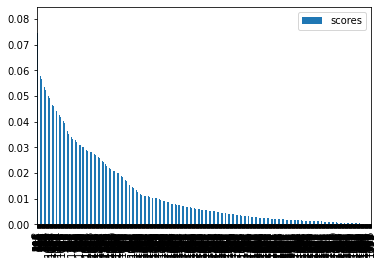

In [48]:
feature_scores_df = feature_scores_df.sort_values(by='scores', ascending=False)
feature_scores_df.plot.bar()

In [49]:
feature_scores_df.drop_duplicates(subset=['scores'], keep='first', inplace=True)

In [50]:
threshold = 0.04
feature_selection = list(feature_scores_df[feature_scores_df['scores'] > threshold]['features'])
len(feature_selection)

90

2:80: E501 line too long (96 > 79 characters)


# Multi-collineairity

In [51]:
# Calculate the Variation Inflation factor (VIF)
X = application_df[feature_selection]
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

       VIF Factor                                        features
0     1103.223247                                      DAYS_BIRTH
1     1105.476841                     DAYS_BIRTH_FLAG_CONT_MOBILE
2       53.895802                      DAYS_BIRTH_DAYS_ID_PUBLISH
3       16.292321              DAYS_BIRTH_HOUR_APPR_PROCESS_START
4   229213.719544      FLAG_EMP_PHONE_REGION_RATING_CLIENT_W_CITY
..            ...                                             ...
85      11.098091                DAYS_ID_PUBLISH_AMT_INCOME_TOTAL
86       8.088843                  DAYS_EMPLOYED_AMT_INCOME_TOTAL
87       6.831149                       DAYS_EMPLOYED_AMT_ANNUITY
88      19.882752  HOUR_APPR_PROCESS_START_REG_CITY_NOT_LIVE_CITY
89      23.465921               DAYS_BIRTH_REG_CITY_NOT_WORK_CITY

[90 rows x 2 columns]


4:80: E501 line too long (87 > 79 characters)


In [52]:
vif_corr = pd.merge(feature_scores_df, vif, how='left', on='features')
vif_corr

,features,scores,VIF Factor
0,DAYS_BIRTH,0.080634,1103.223247
1,DAYS_BIRTH_FLAG_CONT_MOBILE,0.079806,1105.476841
2,DAYS_BIRTH_DAYS_ID_PUBLISH,0.074408,53.895802
3,DAYS_BIRTH_HOUR_APPR_PROCESS_START,0.072029,16.292321
4,FLAG_EMP_PHONE_REGION_RATING_CLIENT_W_CITY,0.069799,229213.719544
...,...,...,...
1147,REG_REGION_NOT_WORK_REGION_FLAG_DOCUMENT_5,0.000009,NaN
1148,REGION_RATING_CLIENT_AMT_CREDIT,0.000006,NaN
1149,REGION_POPULATION_RELATIVE_FLAG_DOCUMENT_20,0.000002,NaN
1150,FLAG_DOCUMENT_20_AMT_INCOME_TOTAL,0.000002,NaN


In [53]:
features_to_drop_1 = ['DAYS_BIRTH_FLAG_MOBIL', 'FLAG_MOBIL_DAYS_LAST_PHONE_CHANGE', 'FLAG_MOBIL_REGION_RATING_CLIENT_W_CITY', 'DAYS_ID_PUBLISH_FLAG_MOBIL', 'FLAG_MOBIL_REGION_RATING_CLIENT', 'FLAG_MOBIL_REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_W_CITY_REG_CITY_NOT_LIVE_CITY', 
                      'DAYS_BIRTH_FLAG_CONT_MOBILE', 'REGION_RATING_CLIENT_W_CITY_REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_FLAG_DOCUMENT_3', 'FLAG_MOBIL_DAYS_LAST_PHONE_CHANGE', 'FLAG_CONT_MOBILE_REGION_RATING_CLIENT_W_CITY', 'DAYS_ID_PUBLISH_FLAG_CONT_MOBILE', 'FLAG_CONT_MOBILE_REGION_RATING_CLIENT', 'FLAG_EMP_PHONE_REG_CITY_NOT_WORK_CITY', 'FLAG_MOBIL_REG_CITY_NOT_WORK_CITY', 'REGION_RATING_CLIENT_REG_CITY_NOT_LIVE_CITY',
                      'DAYS_BIRTH', 'FLAG_MOBIL_REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE_REGION_RATING_CLIENT']

1:80: E501 line too long (281 > 79 characters)
1:282: W291 trailing whitespace
2:80: E501 line too long (433 > 79 characters)


In [54]:
# Drop highly collineair features
application_df.drop(columns=features_to_drop_1, inplace=True)

In [55]:
feature_selection = list(set(feature_selection) - set(features_to_drop_1))

In [56]:
# Calculate the Variation Inflation factor (VIF)
X = application_df[feature_selection]
vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

    VIF Factor                                           features
0     6.231952                  DAYS_REGISTRATION_AMT_GOODS_PRICE
1    14.066711                       DAYS_EMPLOYED_FLAG_EMP_PHONE
2   607.548441                  FLAG_MOBIL_REG_CITY_NOT_LIVE_CITY
3     7.269886  REGION_POPULATION_RELATIVE_DAYS_LAST_PHONE_CHANGE
4    12.084883                 DAYS_BIRTH_HOUR_APPR_PROCESS_START
..         ...                                                ...
71    1.418104                           NAME_INCOME_TYPE_Working
72  143.501814                           DAYS_BIRTH_DAYS_EMPLOYED
73   18.261148          DAYS_REGISTRATION_HOUR_APPR_PROCESS_START
74    5.011916             CNT_FAM_MEMBERS_DAYS_LAST_PHONE_CHANGE
75   94.456923                              DAYS_BIRTH_AMT_CREDIT

[76 rows x 2 columns]


4:80: E501 line too long (87 > 79 characters)


In [57]:
vif_corr = pd.merge(feature_scores_df, vif, how='left', on='features')
vif_corr

,features,scores,VIF Factor
0,DAYS_BIRTH,0.080634,NaN
1,DAYS_BIRTH_FLAG_CONT_MOBILE,0.079806,NaN
2,DAYS_BIRTH_DAYS_ID_PUBLISH,0.074408,43.583797
3,DAYS_BIRTH_HOUR_APPR_PROCESS_START,0.072029,12.084883
4,FLAG_EMP_PHONE_REGION_RATING_CLIENT_W_CITY,0.069799,145.741690
...,...,...,...
1147,REG_REGION_NOT_WORK_REGION_FLAG_DOCUMENT_5,0.000009,NaN
1148,REGION_RATING_CLIENT_AMT_CREDIT,0.000006,NaN
1149,REGION_POPULATION_RELATIVE_FLAG_DOCUMENT_20,0.000002,NaN
1150,FLAG_DOCUMENT_20_AMT_INCOME_TOTAL,0.000002,NaN


In [58]:
# select features below multi-collineairity threshold (VIF >10)
multi_col = list(vif[vif['VIF Factor'] < 10]['features'])
multi_col

['DAYS_REGISTRATION_AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE_DAYS_LAST_PHONE_CHANGE',
 'CNT_FAM_MEMBERS_REG_CITY_NOT_WORK_CITY',
 'CODE_GENDER_M',
 'DAYS_EMPLOYED_DAYS_LAST_PHONE_CHANGE',
 'REG_CITY_NOT_LIVE_CITY_FLAG_DOCUMENT_3',
 'REG_CITY_NOT_LIVE_CITY_AMT_ANNUITY',
 'REG_CITY_NOT_WORK_CITY_AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE_DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH_DAYS_LAST_PHONE_CHANGE',
 'NAME_EDUCATION_TYPE_Secondary / secondary special',
 'REGION_POPULATION_RELATIVE_DAYS_EMPLOYED',
 'DAYS_EMPLOYED_AMT_INCOME_TOTAL',
 'REG_CITY_NOT_WORK_CITY_FLAG_DOCUMENT_3',
 'DAYS_EMPLOYED_DAYS_REGISTRATION',
 'FLAG_EMP_PHONE_FLAG_DOCUMENT_3',
 'DAYS_BIRTH_AMT_INCOME_TOTAL',
 'DAYS_REGISTRATION_DAYS_LAST_PHONE_CHANGE',
 'DAYS_EMPLOYED_CNT_FAM_MEMBERS',
 'DAYS_ID_PUBLISH_AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS_REG_CITY_NOT_LIVE_CITY',
 'DAYS_LAST_PHONE_CHANGE_AMT_ANNUITY',
 'REGION_POPULATION_RELATIVE_DAYS_ID_PUBLISH',
 'DAYS_EMPLOYED_AMT_ANNUITY',
 'NAME_INCOME_TYPE_Working',
 'CNT_FAM_

In [59]:
# select all required columns
no_feat = ['TARGET', 'SK_ID_CURR', 'train']
column_selection = multi_col + no_feat

In [60]:
application_df = application_df[column_selection]

In [61]:
application_df.shape

(302938, 29)

# Standardise features

In [62]:
# Split test and train dataset
train_df = application_df[application_df['train'] == 1].copy()
test_df = application_df[application_df['train'] == 0].copy()

train_df.drop(columns=['train'], inplace=True)
test_df.drop(columns=['train'], inplace=True)

In [65]:
# Split predictor and dependent variables
predictor = 'TARGET'
Y_train = train_df[predictor]
X_train = train_df.drop(predictor, axis=1)
test_df.drop(columns=predictor, inplace=True)

In [66]:
# Create numpy array of SK_ID_CURR to later use for submission file
Customer_Id = test_df['SK_ID_CURR']

In [67]:
# split the data into train and test datasets
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [68]:
# standardise the features
ss = StandardScaler()
x_train = pd.DataFrame(ss.fit_transform(x_train), columns=x_train.columns)
x_test = pd.DataFrame(ss.fit_transform(x_test), columns=x_test.columns)
test_df = pd.DataFrame(ss.fit_transform(test_df), columns=test_df.columns)

# Data export

In [72]:
# Export data to cleaned data folder
x_train.to_csv(cleaned_folder+'x_train.csv', index=False)
x_test.to_csv(cleaned_folder+'x_test.csv', index=False)
y_train.to_csv(cleaned_folder+'y_train.csv', index=False)
y_test.to_csv(cleaned_folder+'y_test.csv', index=False)
test_df.to_csv(cleaned_folder+'test_df.csv', index=False)